This notebook includes studies: 

High confidence (HC)

- Karimi, N., Cvjetkovic, A., Jang, S.C. et al. Detailed analysis of the plasma extracellular vesicle proteome after separation from lipoproteins. Cell. Mol. Life Sci. 75, 2873–2886 (2018). https://doi.org/10.1007/s00018-018-2773-4

- Dhondt, B., Geeurickx, E., Tulkens, J., Van Deun, J., Vergauwen, G., Lippens, L., Miinalainen, I., Rappu, P., Heino, J., Ost, P., Lumen, N., De Wever, O. and Hendrix, A. (2020), Unravelling the proteomic landscape of extracellular vesicles in prostate cancer by density-based fractionation of urine. Journal of Extracellular Vesicles, 9: 1736935. https://doi.org/10.1080/20013078.2020.1736935

- Martínez-Greene, J. A., Hernández-Ortega, K., Quiroz-Baez, R., Resendis-Antonio, O., Pichardo-Casas, I., Sinclair, D. A., Budnik, B., Hidalgo-Miranda, A., Uribe-Querol, E., Ramos-Godínez, M. P., & Martínez-Martínez, E. (2021). Quantitative proteomic analysis of extracellular vesicle subgroups isolated by an optimized method combining polymer-based precipitation and size exclusion chromatography. J. Extracell. Vesicles, 10, e12087. https://doi.org/10.1002/jev2.12087

Low confidence (LC) are EV proteins detected in all EV studies before 2010.
 
Output datasets:
- validation_all.csv
- validation_nonoverlapping.csv

# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import os

from scipy.stats import mannwhitneyu, chi2_contingency, fisher_exact
from statsmodels.stats.multitest import fdrcorrection
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted, venn3, venn3_circles

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Define paths

In [2]:
Data_path = os.path.dirname(os.getcwd()) + '/Data'

# Import data sets

In [3]:
df_all = pd.read_csv(Data_path + "/curated/features_human_proteome.csv")
df_filtered = pd.read_csv(Data_path + "/training/training_data_MS_iso_filter.csv")

df_filtered_EV = df_filtered[df_filtered["EV"] == 1]

## Proteins identified in old studies (2010 and before)

In [4]:
old = pd.read_csv(Data_path + "/curated/VP_old_mapped.csv")
ev_proteins_old = list(old['Uniprot'])
len(ev_proteins_old)

9506

In [5]:
# Select proteins that are not in our training data
training_data_list = list(df_filtered_EV['id'])
non_overlapping = old[~old['Uniprot'].isin(training_data_list)]
len(non_overlapping['Uniprot'])

4097

## High confidence EV protein studies

In [6]:
def get_first_uniprot(string):
    
    if ";" in string:
        first_unirpot, _ = string.split(";", maxsplit=1)
        return first_unirpot
    else: 
        return string

Karimi, N., Cvjetkovic, A., Jang, S.C. et al. Detailed analysis of the plasma extracellular vesicle proteome after separation from lipoproteins. Cell. Mol. Life Sci. 75, 2873–2886 (2018). https://doi.org/10.1007/s00018-018-2773-4

In [7]:
plasma = pd.read_csv(Data_path + "/validation/raw/Karimi2018_plasma_EV_protein_list.txt", sep=" ", header=None, 
    names=["Uniprot"], usecols=[0])
plasma_set = set(plasma["Uniprot"])
print("Number of EV proteins in high confidence plasma dataset:", len(plasma_set))

Number of EV proteins in high confidence plasma dataset: 1187


Dhondt, B., Geeurickx, E., Tulkens, J., Van Deun, J., Vergauwen, G., Lippens, L., Miinalainen, I., Rappu, P., Heino, J., Ost, P., Lumen, N., De Wever, O. and Hendrix, A. (2020), Unravelling the proteomic landscape of extracellular vesicles in prostate cancer by density-based fractionation of urine. Journal of Extracellular Vesicles, 9: 1736935. https://doi.org/10.1080/20013078.2020.1736935

In [8]:
urine = pd.read_csv(Data_path + "/validation/raw/Dhondt2021_urine_EV_proteins.csv", sep=";")
urine["Protein IDs"] = urine["Protein IDs"].apply(get_first_uniprot)
urine_set = set(urine["Protein IDs"])
print("Number of EV proteins in high confidence urine dataset:", len(urine_set))

Number of EV proteins in high confidence urine dataset: 1789


Martínez-Greene, J. A., Hernández-Ortega, K., Quiroz-Baez, R., Resendis-Antonio, O., Pichardo-Casas, I., Sinclair, D. A., Budnik, B., Hidalgo-Miranda, A., Uribe-Querol, E., Ramos-Godínez, M. P., & Martínez-Martínez, E. (2021). Quantitative proteomic analysis of extracellular vesicle subgroups isolated by an optimized method combining polymer-based precipitation and size exclusion chromatography. J. Extracell. Vesicles, 10, e12087. https://doi.org/10.1002/jev2.12087

In [9]:
culture = pd.read_csv(Data_path + "/validation/raw/MartinezGreene2020_cell_culture_EV_proteins.csv", sep=";")
culture.dropna(axis=0, how="all", inplace=True)
culture_set = set(culture["Accession"])
print("Number of EV proteins in high confidence cell culture dataset:", len(culture_set))

Number of EV proteins in high confidence cell culture dataset: 1686


In [10]:
ev_proteins_hc = plasma_set.union(urine_set)
ev_proteins_hc = ev_proteins_hc.union(culture_set)
print("Number of EV proteins in high confidence dataset:", len(ev_proteins_hc))

Number of EV proteins in high confidence dataset: 3243


In [11]:
# select overlapping proteins
validation_dataset = df_all[df_all['id'].isin(ev_proteins_hc)]
len(validation_dataset['id'])
# make it look alike
validation_dataset = validation_dataset.drop(['fasta_sequence'], axis=1)
validation_dataset
# validation_dataset['EV'] = 1

,id,length,hydr_count,polar_count,molecular_weight,helix,turn,sheet,A,C,...,Methylation_MSD,ww_domain,RAS_profile,EGF,RRM,coiled_coil,transmembrane,TMHMM,Polar_exposed,Hydrophobic_exposed
11,P02655,6.658211,0.425743,0.386139,13.675570,0.623762,0.376238,0.000000,0.069307,0.000000,...,0.0,0,0,0,0,0,0,0,0.404255,0.404255
16,O75882,10.480790,0.426172,0.363891,17.491370,0.066480,0.623513,0.310007,0.071379,0.061582,...,0.0,0,0,1,0,1,1,1,0.558984,0.199637
18,P56385,6.108524,0.434783,0.420290,13.160801,0.753623,0.246377,0.000000,0.115942,0.000000,...,0.0,0,0,0,0,0,1,0,0.426471,0.441176
19,P56945,9.764872,0.366667,0.362069,16.734216,0.293103,0.667816,0.039080,0.101149,0.004598,...,1.0,0,0,0,0,0,1,0,0.459510,0.195857
25,P04920,10.277287,0.419823,0.363417,17.281759,0.401289,0.531829,0.066882,0.085415,0.008058,...,1.0,0,0,0,0,1,1,1,0.499184,0.231648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20324,Q9BTW9,10.219169,0.467282,0.373322,17.233049,0.700503,0.299497,0.000000,0.095638,0.026007,...,0.0,0,0,0,0,0,0,0,0.636816,0.136816
20329,P09493,8.149747,0.366197,0.570423,15.206297,0.982394,0.017606,0.000000,0.126761,0.003521,...,0.0,0,0,0,0,1,0,0,0.762136,0.169903
20341,Q9NY65,8.810572,0.434298,0.398664,15.827793,0.436526,0.403118,0.160356,0.082405,0.026726,...,1.0,0,0,0,0,0,0,0,0.718310,0.133803
20346,P60174,7.960002,0.433735,0.377510,14.926271,0.461847,0.381526,0.156627,0.112450,0.020080,...,0.0,0,0,0,0,0,0,0,0.633333,0.144444


In [12]:
# Select proteins that are not in our training data
training_data_list = list(df_filtered_EV['id'])
non_overlapping = validation_dataset[~validation_dataset['id'].isin(training_data_list)]
len(non_overlapping['id'])

573

In [13]:
# Combine datasets
validation_dataset["EV"] = 2
df_concat = pd.concat([df_filtered, validation_dataset])
df_concat

,id,length,hydr_count,polar_count,molecular_weight,helix,turn,sheet,A,C,...,ww_domain,RAS_profile,EGF,RRM,coiled_coil,transmembrane,TMHMM,Polar_exposed,Hydrophobic_exposed,EV
0,Q92667,9.818582,0.376523,0.370986,16.793404,0.079734,0.805094,0.115172,0.079734,0.018826,...,0,0,0,0,1,1,1,0.447738,0.263651,1
1,P62736,8.558421,0.427056,0.379310,15.574035,0.445623,0.347480,0.206897,0.076923,0.018568,...,0,0,0,0,0,0,0,0.682540,0.111111,1
2,Q9H553,8.700440,0.471154,0.358173,15.735720,0.485577,0.375000,0.139423,0.072115,0.028846,...,0,0,0,0,0,1,0,0.614286,0.185714,1
3,P0C7M7,9.179909,0.424138,0.379310,16.216178,0.320690,0.448276,0.231034,0.058621,0.022414,...,0,0,0,0,0,0,0,0.661111,0.088889,0
4,P49703,7.651052,0.417910,0.402985,14.652697,0.328358,0.477612,0.194030,0.099502,0.004975,...,0,0,0,0,0,0,0,0.567010,0.195876,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20324,Q9BTW9,10.219169,0.467282,0.373322,17.233049,0.700503,0.299497,0.000000,0.095638,0.026007,...,0,0,0,0,0,0,0,0.636816,0.136816,2
20329,P09493,8.149747,0.366197,0.570423,15.206297,0.982394,0.017606,0.000000,0.126761,0.003521,...,0,0,0,0,1,0,0,0.762136,0.169903,2
20341,Q9NY65,8.810572,0.434298,0.398664,15.827793,0.436526,0.403118,0.160356,0.082405,0.026726,...,0,0,0,0,0,0,0,0.718310,0.133803,2
20346,P60174,7.960002,0.433735,0.377510,14.926271,0.461847,0.381526,0.156627,0.112450,0.020080,...,0,0,0,0,0,0,0,0.633333,0.144444,2


In [14]:
df_concat.value_counts("EV")

EV
0    10290
1     5965
2     3222
dtype: int64

# Calculate significance

In [15]:
features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight',
       'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
       'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed',
       'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed', 'G_exposed',
       'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed',
       'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed',
       'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
       'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity',
       'Instability_index', 'Gravy', 'isoelectric_point', 'charge_at_7',
       'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed']

features_categorical = ['HSP', 'PTM_UP', 'Citrullination_UP', 'GPI-anchor_UP',
       'Nitration_UP', 'Prenylation_UP', 'ISGylation_UP',
       'NEDDylation_UP', 'Acetylation_all', 'Glycosylation_all',
       'Methylation_all', 'Myristoylation_all', 'Nitrosylation_all',
       'Palmitoylation_all', 'Phosphorylation_all', 'SUMOylation_all',
       'Ubiquitination_all', 'PTM_MSD', 'Phosphorylation_MSD',
       'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD',
       'Acetylation_MSD', 'Palmitoylation_MSD', 'Methylation_MSD',
       'coiled_coil', 'RAS_profile', 'ww_domain', 'EGF', 'RRM', 'transmembrane', 'TMHMM']

EV_yes = df_concat[df_concat["EV"] == 1]
EV_no = df_concat[df_concat["EV"] == 0]
Validation_EVs = df_concat[df_concat["EV"] == 2]

## Compare non-EVs and Validation EVs

In [16]:
# Mann-Whitney U test

# create Series to save p-values
p_vals = pd.Series(index=features_continuous, dtype="float64", name='p_value')

# calculate p-values using Mann-Whitney U Test
for i, feature in enumerate(features_continuous):
    
    stat, p = mannwhitneyu(EV_no[feature], Validation_EVs[feature]) # function return statistic and p-value
    p_vals[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj = fdrcorrection(p_vals)
# create Series to save adjusted p-values
p_vals_adj = pd.Series(data=p_vals_adj, index=features_continuous, name='p_value_adjusted')

# save both p-values in dataframe
p_vals_comb_val_EV = pd.concat([p_vals, p_vals_adj], axis=1)

In [17]:
# Fisher's exact test

# create Series to save p-values
p_vals_cat = pd.Series(index=features_categorical, dtype="float64", name='p_value')

# calculate p-values using Fisher's exact test
for i, feature in enumerate(features_categorical):
    
    # get counts for each category
    A = sum(EV_no[feature]) # EV & positive
    B = len(EV_no[feature]) - sum(EV_no[feature]) # EV & negative
    C = sum(Validation_EVs[feature]) # no EV & positive
    D = len(Validation_EVs[feature]) - sum(Validation_EVs[feature]) # no EV & negative
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B],
                      [C, D]])
    
    odds, p = fisher_exact(table, alternative='two-sided') # function return odds ratio and p-value
    p_vals_cat[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj_cat = fdrcorrection(p_vals_cat)
# create Series to save adjusted p-values
p_vals_adj_cat = pd.Series(data=p_vals_adj_cat, index=features_categorical, name='p_value_adjusted')

# save both p-values in dataframe
p_vals_comb_val_EV_cat = pd.concat([p_vals_cat, p_vals_adj_cat], axis=1)

# concat both p-value dataframes
p_vals_comb_val_EV = pd.concat([p_vals_comb_val_EV, p_vals_comb_val_EV_cat], axis=0)

## Compare non-EVs and EVs in our discovery set

In [18]:
# Mann-Whitney U test
from scipy.stats import mannwhitneyu, chi2_contingency, fisher_exact
from statsmodels.stats.multitest import fdrcorrection

# create Series to save p-values
p_vals = pd.Series(index=features_continuous, dtype="float64", name='p_value')

# calculate p-values using Mann-Whitney U Test
for i, feature in enumerate(features_continuous):
    
    stat, p = mannwhitneyu(EV_no[feature], EV_yes[feature]) # function return statistic and p-value
    p_vals[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj = fdrcorrection(p_vals)
# create Series to save adjusted p-values
p_vals_adj = pd.Series(data=p_vals_adj, index=features_continuous, name='p_value_adjusted')

# save both p-values in dataframe
p_vals_comb_main_EV = pd.concat([p_vals, p_vals_adj], axis=1)

In [19]:
# Fisher's exact test

# create Series to save p-values
p_vals_cat = pd.Series(index=features_categorical, dtype="float64", name='p_value')

# calculate p-values using Fisher's exact test
for i, feature in enumerate(features_categorical):
    
    # get counts for each category
    A = sum(EV_no[feature]) # EV & positive
    B = len(EV_no[feature]) - sum(EV_no[feature]) # EV & negative
    C = sum(EV_yes[feature]) # no EV & positive
    D = len(EV_yes[feature]) - sum(EV_yes[feature]) # no EV & negative
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B],
                      [C, D]])
    
    odds, p = fisher_exact(table, alternative='two-sided') # function return odds ratio and p-value
    p_vals_cat[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj_cat = fdrcorrection(p_vals_cat)
# create Series to save adjusted p-values
p_vals_adj_cat = pd.Series(data=p_vals_adj_cat, index=features_categorical, name='p_value_adjusted')

# save both p-values in dataframe
p_vals_comb_main_EV_cat = pd.concat([p_vals_cat, p_vals_adj_cat], axis=1)

# concat both p-value dataframes
p_vals_comb_main_EV = pd.concat([p_vals_comb_main_EV, p_vals_comb_main_EV_cat], axis=0)

# Adding proteins identified in old studies 

In [20]:
# select overlapping proteins
old_dataset = df_all[df_all['id'].isin(ev_proteins_old)]
# make it look alike
old_dataset = old_dataset.drop(['fasta_sequence'], axis=1)
# Combine datasets
old_dataset["EV"] = 3
df_concat = pd.concat([df_concat, old_dataset])
df_concat

,id,length,hydr_count,polar_count,molecular_weight,helix,turn,sheet,A,C,...,ww_domain,RAS_profile,EGF,RRM,coiled_coil,transmembrane,TMHMM,Polar_exposed,Hydrophobic_exposed,EV
0,Q92667,9.818582,0.376523,0.370986,16.793404,0.079734,0.805094,0.115172,0.079734,0.018826,...,0,0,0,0,1,1,1,0.447738,0.263651,1
1,P62736,8.558421,0.427056,0.379310,15.574035,0.445623,0.347480,0.206897,0.076923,0.018568,...,0,0,0,0,0,0,0,0.682540,0.111111,1
2,Q9H553,8.700440,0.471154,0.358173,15.735720,0.485577,0.375000,0.139423,0.072115,0.028846,...,0,0,0,0,0,1,0,0.614286,0.185714,1
3,P0C7M7,9.179909,0.424138,0.379310,16.216178,0.320690,0.448276,0.231034,0.058621,0.022414,...,0,0,0,0,0,0,0,0.661111,0.088889,0
4,P49703,7.651052,0.417910,0.402985,14.652697,0.328358,0.477612,0.194030,0.099502,0.004975,...,0,0,0,0,0,0,0,0.567010,0.195876,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20366,P0DTE7,8.997179,0.409002,0.381605,16.030862,0.254403,0.542074,0.203523,0.052838,0.023483,...,0,0,0,0,0,0,0,0.633588,0.076336,3
20367,P26368,8.891784,0.366316,0.429474,15.920828,0.178947,0.604211,0.216842,0.056842,0.012632,...,0,0,0,1,0,0,0,0.621849,0.130252,3
20368,Q5GH77,8.842350,0.520697,0.333333,15.912944,0.701525,0.298475,0.000000,0.045752,0.021786,...,0,0,0,0,0,1,1,0.519774,0.322034,3
20371,Q96H40,8.854868,0.330454,0.498920,15.918914,0.399568,0.494600,0.105832,0.032397,0.056156,...,0,0,0,0,0,0,0,0.659664,0.105042,3


## Compare non-EVs and EVs in old datasets

In [21]:
features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight',
       'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
       'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed',
       'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed', 'G_exposed',
       'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed',
       'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed',
       'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
       'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity',
       'Instability_index', 'Gravy', 'isoelectric_point', 'charge_at_7',
       'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed']

features_categorical = ['HSP', 'PTM_UP', 'Citrullination_UP', 'GPI-anchor_UP',
       'Nitration_UP', 'Prenylation_UP', 'ISGylation_UP',
       'NEDDylation_UP', 'Acetylation_all', 'Glycosylation_all',
       'Methylation_all', 'Myristoylation_all', 'Nitrosylation_all',
       'Palmitoylation_all', 'Phosphorylation_all', 'SUMOylation_all',
       'Ubiquitination_all', 'PTM_MSD', 'Phosphorylation_MSD',
       'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD',
       'Acetylation_MSD', 'Palmitoylation_MSD', 'Methylation_MSD',
       'coiled_coil', 'RAS_profile', 'ww_domain', 'EGF', 'RRM', 'transmembrane', 'TMHMM']

old_EVs = df_concat[df_concat["EV"] == 3]

In [22]:
# Mann-Whitney U test

# create Series to save p-values
p_vals = pd.Series(index=features_continuous, dtype="float64", name='p_value')

# calculate p-values using Mann-Whitney U Test
for i, feature in enumerate(features_continuous):
    
    stat, p = mannwhitneyu(EV_no[feature], old_EVs[feature]) # function return statistic and p-value
    p_vals[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj = fdrcorrection(p_vals)
# create Series to save adjusted p-values
p_vals_adj = pd.Series(data=p_vals_adj, index=features_continuous, name='p_value_adjusted')

# save both p-values in dataframe
p_vals_comb_old_EV = pd.concat([p_vals, p_vals_adj], axis=1)

In [23]:
# Fisher's exact test

# create Series to save p-values
p_vals_cat = pd.Series(index=features_categorical, dtype="float64", name='p_value')

# calculate p-values using Fisher's exact test
for i, feature in enumerate(features_categorical):
    
    # get counts for each category
    A = sum(EV_no[feature]) # EV & positive
    B = len(EV_no[feature]) - sum(EV_no[feature]) # EV & negative
    C = sum(old_EVs[feature]) # no EV & positive
    D = len(old_EVs[feature]) - sum(old_EVs[feature]) # no EV & negative
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B],
                      [C, D]])
    
    odds, p = fisher_exact(table, alternative='two-sided') # function return odds ratio and p-value
    p_vals_cat[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj_cat = fdrcorrection(p_vals_cat)
# create Series to save adjusted p-values
p_vals_adj_cat = pd.Series(data=p_vals_adj_cat, index=features_categorical, name='p_value_adjusted')

# save both p-values in dataframe
p_vals_comb_EV_old_cat = pd.concat([p_vals_cat, p_vals_adj_cat], axis=1)

# concat both p-value dataframes
p_vals_comb_old_EV = pd.concat([p_vals_comb_old_EV, p_vals_comb_EV_old_cat], axis=0)

In [24]:
def print_p_val(p_val):
    
    if p_val < 0.0001:
        return "<0.0001"
    else:
        return "%.4f" % p_val

In [25]:
# figure settings
sns.set(style=("ticks"), font_scale=1.2)
x1, x2, x3, x4 = 0, 1, 2, 3 
my_pal = {2: "lightcyan", 1: "cornflowerblue", 3:"orange", 0: "darkblue"}
labels = ["HC EV", "EV", "LC EV", "non-EV"]

In [26]:
p_vals_comb_old_EV.loc["molecular_weight", "p_value_adjusted"]

3.5734984352785645e-07

Text(1.5, 1.2289808917197453, '<0.0001')

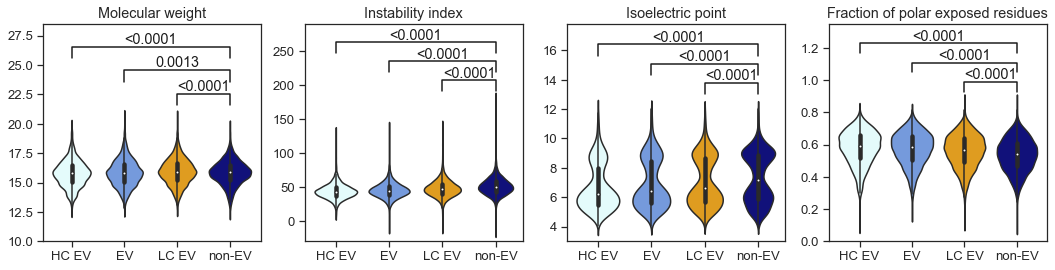

In [27]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False, figsize=(18, 4))

#################### plot 1 #######################
feature="molecular_weight"
sns.violinplot(x="EV", y=feature, data=df_concat, ax=ax1, order=[2, 1, 3, 0], palette=my_pal)
ax1.set(ylabel=None, xlabel=None, title="Molecular weight", xticklabels=(labels), ylim=(10, 28.5))
y, h, col = df_concat[feature].max() + 0.8, 1, 'k'
ax1.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x3+x4)*.5, y+h, print_p_val(p_vals_comb_old_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 2.8, 1, 'k'
ax1.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x2+x4)*.5, y+h, print_p_val(p_vals_comb_main_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 4.8, 1, 'k'
ax1.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x4)*.5, y+h, print_p_val(p_vals_comb_val_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)


#################### plot 2 #######################
feature="Instability_index"
sns.violinplot(x="EV", y=feature, data=df_concat, ax=ax2, order=[2, 1, 3, 0], palette=my_pal)
ax2.set(ylabel=None, xlabel=None, title="Instability index", xticklabels=(labels), ylim=(-30, 290))
y, h, col = df_concat[feature].max() + 7, 15, 'k'
ax2.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x3+x4)*.5, y+h, print_p_val(p_vals_comb_old_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 35, 15, 'k'
ax2.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x2+x4)*.5, y+h, print_p_val(p_vals_comb_main_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 63, 15, 'k'
ax2.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x4)*.5, y+h, print_p_val(p_vals_comb_val_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)


#################### plot 3 #######################
feature="isoelectric_point"
sns.violinplot(x="EV", y=feature, data=df_concat, ax=ax3, order=[2, 1, 3, 0], palette=my_pal)
ax3.set(ylabel=None, xlabel=None, title="Isoelectric point", xticklabels=(labels), ylim=(3, 17.8))
y, h, col = df_concat[feature].max() + 1, 0.8, 'k'
ax3.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x3+x4)*.5, y+h, print_p_val(p_vals_comb_old_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 2.3, 0.8, 'k'
ax3.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x2+x4)*.5, y+h, print_p_val(p_vals_comb_main_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 3.6, 0.8, 'k'
ax3.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x1+x4)*.5, y+h, print_p_val(p_vals_comb_val_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)

#################### plot 4 #######################
feature="Polar_exposed"
sns.violinplot(x="EV", y=feature, data=df_concat, ax=ax4, order=[2, 1, 3, 0], palette=my_pal)
ax4.set(ylabel=None, xlabel=None, title="Fraction of polar exposed residues", xticklabels=(labels), ylim=(0, 1.35))
y, h, col = df_concat[feature].max() + 0.05, 0.06, 'k'
ax4.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x3+x4)*.5, y+h, print_p_val(p_vals_comb_old_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 0.17, 0.06, 'k'
ax4.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x2+x4)*.5, y+h, print_p_val(p_vals_comb_main_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 0.29, 0.06, 'k'
ax4.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x1+x4)*.5, y+h, print_p_val(p_vals_comb_val_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)

Text(1.5, 1.44, '<0.0001')

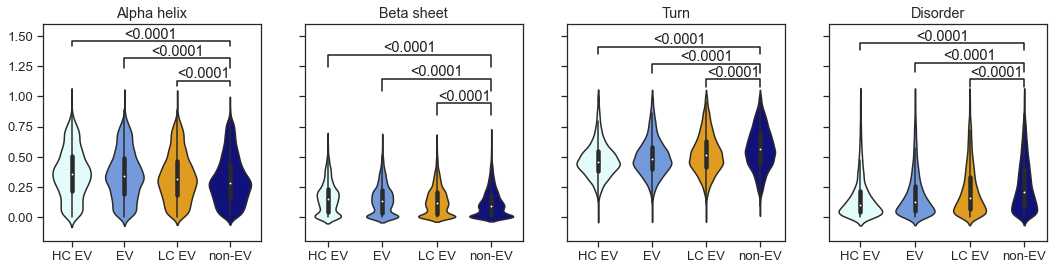

In [28]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(18, 4))
plt.ylim((-0.2, 1.6))

#################### plot 1 #######################
feature="helix"
sns.violinplot(x="EV", y=feature, data=df_concat, ax=ax1, order=[2, 1, 3, 0], palette=my_pal)
ax1.set(ylabel=None, xlabel=None, title="Alpha helix", xticklabels=(labels))
y, h, col = df_concat[feature].max() + 0.1, 0.04, 'k'
ax1.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x3+x4)*.5, y+h, print_p_val(p_vals_comb_old_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 0.25, 0.08, 'k'
ax1.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x2+x4)*.5, y+h, print_p_val(p_vals_comb_main_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 0.43, 0.04, 'k'
ax1.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x4)*.5, y+h, print_p_val(p_vals_comb_val_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)


#################### plot 2 #######################
feature="sheet"
sns.violinplot(x="EV", y=feature, data=df_concat, ax=ax2, order=[2, 1, 3, 0], palette=my_pal)
ax2.set(ylabel=None, xlabel=None, title="Beta sheet", xticklabels=(labels))
y, h, col = df_concat[feature].max() + 0.15, 0.1, 'k'
ax2.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x3+x4)*.5, y+h, print_p_val(p_vals_comb_old_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 0.35, 0.1, 'k'
ax2.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x2+x4)*.5, y+h, print_p_val(p_vals_comb_main_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 0.55, 0.1, 'k'
ax2.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x4)*.5, y+h, print_p_val(p_vals_comb_val_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)


#################### plot 3 #######################
feature="turn"
sns.violinplot(x="EV", y=feature, data=df_concat, ax=ax3, order=[2, 1, 3, 0], palette=my_pal)
ax3.set(ylabel=None, xlabel=None, title="Turn", xticklabels=(labels))
y, h, col = df_concat[feature].max() + 0.08, 0.06, 'k'
ax3.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x3+x4)*.5, y+h, print_p_val(p_vals_comb_old_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 0.19, 0.08, 'k'
ax3.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x2+x4)*.5, y+h, print_p_val(p_vals_comb_main_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 0.35, 0.06, 'k'
ax3.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x1+x4)*.5, y+h, print_p_val(p_vals_comb_val_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)

#################### plot 4 #######################
feature="disorder"
sns.violinplot(x="EV", y=feature, data=df_concat, ax=ax4, order=[2, 1, 3, 0], palette=my_pal)
ax4.set(ylabel=None, xlabel=None, title="Disorder", xticklabels=(labels));
y, h, col = df_concat[feature].max() + 0.08, 0.06, 'k'
ax4.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x3+x4)*.5, y+h, print_p_val(p_vals_comb_old_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 0.2, 0.08, 'k'
ax4.plot([x2, x2, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x2+x4)*.5, y+h, print_p_val(p_vals_comb_main_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)
y, h, col = df_concat[feature].max() + 0.38, 0.06, 'k'
ax4.plot([x1, x1, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x1+x4)*.5, y+h, print_p_val(p_vals_comb_val_EV.loc[feature, "p_value_adjusted"]), ha='center', va='bottom', color=col)

In [29]:
# figure settings
sns.set(style=("ticks"), font_scale=1.2)
x1, x2, x3, x4 = 0, 1, 2, 3 
my_pal = {2: "lightcyan", 1: "cornflowerblue", 3:"orange", 0: "darkblue"}
labels = ["HC EV", "EV", "LC EV",  "non-EV"]

def annot_stat(star, x1, x2, y, h, col='k', ax=None):
    ax = plt.gca() if ax is None else ax
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, star, ha='center', va='bottom', color=col)

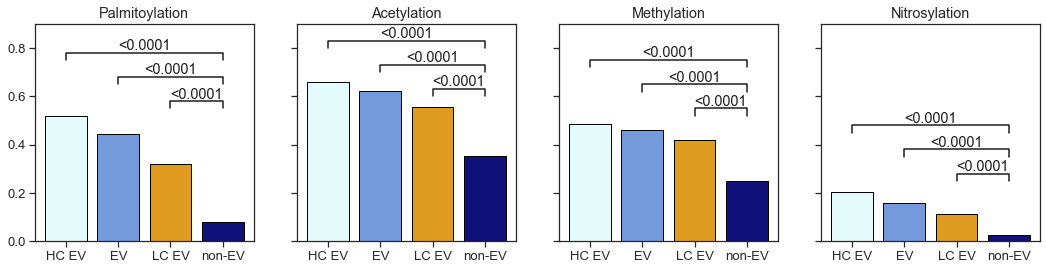

In [30]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(18, 4))
plt.ylim((0, 0.9))

sns.barplot(x="EV", y="Palmitoylation_all", data=df_concat, ax=ax1, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax1.set(ylabel=None, xlabel=None, title="Palmitoylation", xticklabels=(labels))
annot_stat(print_p_val(p_vals_comb_old_EV.loc["Palmitoylation_all", "p_value_adjusted"]), 3, 2, 0.55, 0.03, ax=ax1)
annot_stat(print_p_val(p_vals_comb_main_EV.loc["Palmitoylation_all", "p_value_adjusted"]), 1, 3, 0.65, 0.03, ax=ax1)
annot_stat(print_p_val(p_vals_comb_val_EV.loc["Palmitoylation_all", "p_value_adjusted"]), 0, 3, 0.75, 0.03, ax=ax1)


sns.barplot(x="EV", y="Acetylation_all", data=df_concat, ax=ax2, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax2.set(ylabel=None, xlabel=None, title="Acetylation", xticklabels=(labels))
annot_stat(print_p_val(p_vals_comb_old_EV.loc["Acetylation_all", "p_value_adjusted"]), 3, 2, 0.6, 0.03, ax=ax2)
annot_stat(print_p_val(p_vals_comb_main_EV.loc["Acetylation_all", "p_value_adjusted"]), 1, 3, 0.7, 0.03, ax=ax2)
annot_stat(print_p_val(p_vals_comb_val_EV.loc["Acetylation_all", "p_value_adjusted"]), 0, 3, 0.8, 0.03, ax=ax2)


sns.barplot(x="EV", y="Methylation_all", data=df_concat, ax=ax3, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax3.set(ylabel=None, xlabel=None, title="Methylation", xticklabels=(labels));
annot_stat(print_p_val(p_vals_comb_old_EV.loc["Methylation_all", "p_value_adjusted"]), 3, 2, 0.52, 0.03, ax=ax3)
annot_stat(print_p_val(p_vals_comb_main_EV.loc["Methylation_all", "p_value_adjusted"]), 1, 3, 0.62, 0.03, ax=ax3)
annot_stat(print_p_val(p_vals_comb_val_EV.loc["Methylation_all", "p_value_adjusted"]), 0, 3, 0.72, 0.03, ax=ax3)

sns.barplot(x="EV", y="Nitrosylation_all", data=df_concat, ax=ax4, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax4.set(ylabel=None, xlabel=None, title="Nitrosylation", xticklabels=(labels))
annot_stat(print_p_val(p_vals_comb_old_EV.loc["Nitrosylation_all", "p_value_adjusted"]), 3, 2, 0.25, 0.03, ax=ax4)
annot_stat(print_p_val(p_vals_comb_main_EV.loc["Nitrosylation_all", "p_value_adjusted"]), 1, 3, 0.35, 0.03, ax=ax4)
annot_stat(print_p_val(p_vals_comb_val_EV.loc["Nitrosylation_all", "p_value_adjusted"]), 0, 3, 0.45, 0.03, ax=ax4)

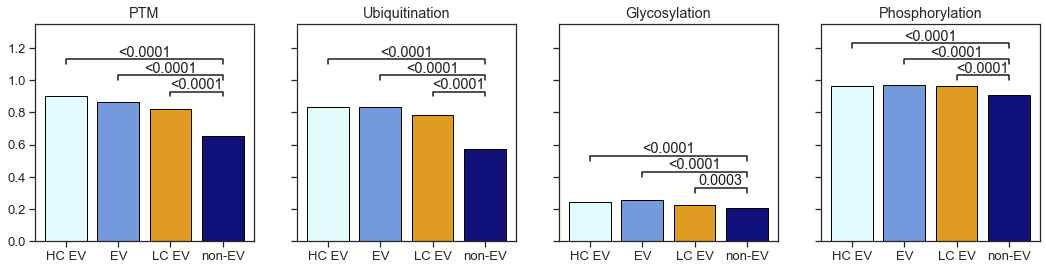

In [31]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(18, 4))
plt.ylim((0, 1.35))

sns.barplot(x="EV", y="PTM_UP", data=df_concat, ax=ax1, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax1.set(ylabel=None, xlabel=None, title="PTM", xticklabels=(labels))
annot_stat(print_p_val(p_vals_comb_old_EV.loc["PTM_UP", "p_value_adjusted"]), 3, 2, 0.9, 0.03, ax=ax1)
annot_stat(print_p_val(p_vals_comb_main_EV.loc["PTM_UP", "p_value_adjusted"]), 1, 3, 1, 0.03, ax=ax1)
annot_stat(print_p_val(p_vals_comb_val_EV.loc["PTM_UP", "p_value_adjusted"]), 0, 3, 1.1, 0.03, ax=ax1)


sns.barplot(x="EV", y="Ubiquitination_all", data=df_concat, ax=ax2, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax2.set(ylabel=None, xlabel=None, title="Ubiquitination", xticklabels=(labels))
annot_stat(print_p_val(p_vals_comb_old_EV.loc["Ubiquitination_all", "p_value_adjusted"]), 3, 2, 0.9, 0.03, ax=ax2)
annot_stat(print_p_val(p_vals_comb_main_EV.loc["Ubiquitination_all", "p_value_adjusted"]), 1, 3, 1, 0.03, ax=ax2)
annot_stat(print_p_val(p_vals_comb_val_EV.loc["Ubiquitination_all", "p_value_adjusted"]), 0, 3, 1.1, 0.03, ax=ax2)


sns.barplot(x="EV", y="Glycosylation_all", data=df_concat, ax=ax3, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax3.set(ylabel=None, xlabel=None, title="Glycosylation", xticklabels=(labels));
annot_stat(print_p_val(p_vals_comb_old_EV.loc["Glycosylation_all", "p_value_adjusted"]), 3, 2, 0.3, 0.03, ax=ax3)
annot_stat(print_p_val(p_vals_comb_main_EV.loc["Glycosylation_all", "p_value_adjusted"]), 1, 3, 0.4, 0.03, ax=ax3)
annot_stat(print_p_val(p_vals_comb_val_EV.loc["Glycosylation_all", "p_value_adjusted"]), 0, 3, 0.5, 0.03, ax=ax3)

sns.barplot(x="EV", y="Phosphorylation_all", data=df_concat, ax=ax4, order=[2, 1, 3, 0], palette=my_pal, edgecolor="black", ci=None)
ax4.set(ylabel=None, xlabel=None, title="Phosphorylation", xticklabels=(labels))
annot_stat(print_p_val(p_vals_comb_old_EV.loc["Phosphorylation_all", "p_value_adjusted"]), 3, 2, 1, 0.03, ax=ax4)
annot_stat(print_p_val(p_vals_comb_main_EV.loc["Phosphorylation_all", "p_value_adjusted"]), 1, 3, 1.1, 0.03, ax=ax4)
annot_stat(print_p_val(p_vals_comb_val_EV.loc["Phosphorylation_all", "p_value_adjusted"]), 0, 3, 1.2, 0.03, ax=ax4)